In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

In [7]:
parquet_path = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet/Global_slopes_corrected.parquet"     # large parquet with node_id, slope1
shp_path     = "/Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/NA/na_sword_nodes_hb74_v16.shp"         # large shapefile with node_id
out_path     = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_74.parquet"    # output GeoParquet

# --- 1) Read needed columns from Parquet (fast & memory efficient)
pq = pd.read_parquet(parquet_path, columns=["node_id", "slope1"])

# Ensure matching dtype for merging (robust choice: treat node_id as string)
pq["node_id"] = pq["node_id"].astype(str)

# --- Keep only the first slope1 per node_id
pq_first = (
    pq.dropna(subset=["node_id"])
      .drop_duplicates(subset=["node_id"], keep="first")
      [["node_id", "slope1"]]
)

print(f"Unique nodes in parquet: {len(pq_first):,}")

# --- 2) Load shapefile
gdf = gpd.read_file(shp_path, engine="pyogrio")
gdf["node_id"] = gdf["node_id"].astype(str)

print(f"Nodes in shapefile: {len(gdf):,}")

# --- 3) Merge & Filter unmatched nodes
gdf_merged = gdf.merge(pq_first, on="node_id", how="left", validate="m:1")

# Count mismatches before filtering
missing_count = gdf_merged["slope1"].isna().sum()
print(f"Unmatched nodes dropped: {missing_count:,}")

# Drop rows where slope1 was not found
gdf_merged = gdf_merged.dropna(subset=["slope1"])

# (Optional but safe) ensure numeric type
gdf_merged["slope1"] = pd.to_numeric(gdf_merged["slope1"], errors="coerce")

print(f"Final matched nodes: {len(gdf_merged):,}")

# --- 4) Save as GeoParquet
gdf_merged.to_parquet(out_path, index=False)

print(f"✅ Done! Merged dataset saved to:\n{out_path}")
print(f"Done. Wrote {len(gdf_merged):,} rows to {out_path}")


Unique nodes in parquet: 1,290,028
Nodes in shapefile: 287,693
Unmatched nodes dropped: 249,396
Final matched nodes: 38,297
✅ Done! Merged dataset saved to:
/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_74.parquet
Done. Wrote 38,297 rows to /Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_74.parquet


In [8]:

df = pd.read_parquet("/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_74.parquet")
df

x          y         node_id    node_len     reach_id  wse  \
0     -89.756485  30.451361  74100600030011  194.209310  74100600031  4.3   
1     -89.758359  30.451384  74100600030021  194.593941  74100600031  4.3   
2     -89.761604  30.453687  74100600030041  175.687018  74100600031  4.3   
3     -89.762901  30.458801  74100600030071  213.564725  74100600031  4.3   
4     -89.777783  30.470487  74100600030181  166.982267  74100600031  4.4   
...          ...        ...             ...         ...          ...  ...   
38292 -91.247745  29.631066  74300500110391  161.637883  74300500111  0.0   
38293 -91.255218  29.627818  74300500110431  158.136646  74300500111  0.0   
38294 -91.256665  29.621204  74300500110471  161.010769  74300500111  0.0   
38295 -91.255978  29.617650  74300500110491  213.989584  74300500111  0.0   
38296 -91.246996  29.605421  74300500110571  215.019104  74300500111  0.0   

       wse_var       width    width_var           facc  ...  max_width  \
0          0.0  108.000000  1001.472222    3177.681885  ...      108.0   
1          0.0  119.000000   362.138889    3177.139847  ...      119.0   
2          0.0   75.000000   238.560000    3176.055771  ...       75.0   
3          0.0  107.000000    54.408163    3174.429657  ...      107.0   
4          0.0  138.000000   308.800000    3168.467240  ...      138.0   
...        ...         ...          ...            ...  ...        ...   
38292      0.0  501.947388     0.000000  252680.078125  ...     4329.0   
38293      0.0  421.285034     0.000000  252680.078125  ...     4329.0   
38294      0.0  436.975586     1.610471  252680.078125  ...     4329.0   
38295      0.0  464.234833   134.293028  252680.078125  ...     4329.0   
38296      0.0  552.753174     0.000000  252680.078125  ...     4329.0   

       manual_add    meand_len  sinuosity  type  \
0               1  5701.366171   1.098154     1   
1               0  5701.366171   1.098154     1   
2               0  4926.982044   1.081963     1   
3               0   782.840403   1.000846     1   
4               0  3773.705280   1.207400     1   
...           ...          ...        ...   ...   
38292           0  1451.206395   1.392671     1   
38293           0  1451.206395   1.392671     1   
38294           0   988.135575   1.166610     1   
38295           0   867.476341   1.138369     1   
38296           0  1083.687040   1.238358     1   

                           river_name  edit_flag  trib_flag  \
0                    West Pearl River        NaN          0   
1                    West Pearl River        NaN          0   
2                    West Pearl River        NaN          0   
3                    West Pearl River        NaN          0   
4                    West Pearl River        NaN          0   
...                               ...        ...        ...   
38292  Atchafalaya Basin Main Channel        NaN          0   
38293  Atchafalaya Basin Main Channel        NaN          0   
38294  Atchafalaya Basin Main Channel        NaN          0   
38295  Atchafalaya Basin Main Channel        NaN          0   
38296  Atchafalaya Basin Main Channel        NaN          0   

                                                geometry    slope1  
0      b'\x01\x01\x00\x00\x00\xdc]\xe7?jpV\xc0\xd3P\x...  0.027942  
1      b'\x01\x01\x00\x00\x00E\xe9\xe5\xf5\x88pV\xc0\...  0.025584  
2      b'\x01\x01\x00\x00\x00X\xb3\xf5\x1c\xbepV\xc0\...  0.009753  
3      b'\x01\x01\x00\x00\x00g\xee\xe5]\xd3pV\xc0;\xd...  0.014284  
4      b'\x01\x01\x00\x00\x00" \xf42\xc7qV\xc0`\xb4;\...  0.010559  
...                                                  ...       ...  
38292  b'\x01\x01\x00\x00\x00\xadw\xe9\x0e\xdb\xcfV\x...  0.000223  
38293  b'\x01\x01\x00\x00\x00\x01\xe4.|U\xd0V\xc0\xf8...  0.000306  
38294  b'\x01\x01\x00\x00\x00\xb5\xb8\xfa4m\xd0V\xc0\...  0.000506  
38295  b'\x01\x01\x00\x00\x00S\xa7\xc1\xf1a\xd0V\xc0\...  0.000169  
38296  b'\x01\x01\x00\x00\x00\xda7\xf9\xc8\xce\xcfV\x...  0.000203  

[3

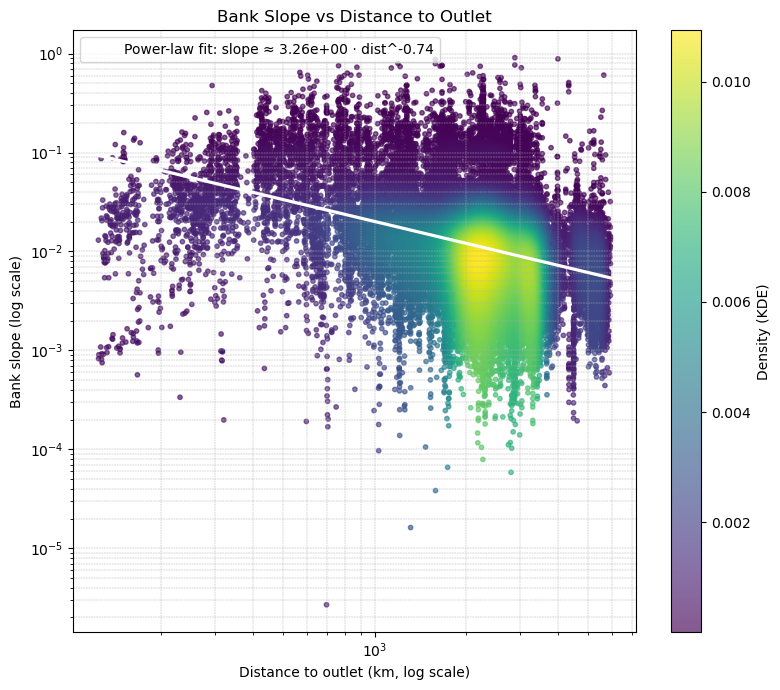

log10(a) = 0.5137819738254743
b = -0.7368886863390409
Trend equation:
Slope ≈ 3.26 · Distance^-0.737


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import HuberRegressor

# Filter & convert distance
d = df[(df['dist_out'] > 0) & (df['slope1'] > 0)].copy()
d['dist_km'] = d['dist_out'] / 1000.0

x = d['dist_km'].values
y = d['slope1'].values

# === Robust power-law regression in log-log space ===
logx = np.log10(x)
logy = np.log10(y)

model = HuberRegressor()
model.fit(logx.reshape(-1,1), logy)

# Create smooth trend line
logx_fit = np.linspace(logx.min(), logx.max(), 200)
logy_pred = model.predict(logx_fit.reshape(-1,1))

x_fit = 10**logx_fit
y_fit = 10**logy_pred

# === KDE Density ===
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()

x, y, z = x[idx], y[idx], z[idx]

# === Plot ===
plt.figure(figsize=(8,7))
sc = plt.scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.65)

# Power-law trend overlay
plt.plot(x_fit, y_fit, color='white', linewidth=2.3,
         label=f"Power-law fit: slope ≈ {10**model.intercept_:.2e} · dist^{model.coef_[0]:.2f}")

plt.xscale("log")
plt.yscale("log")

plt.grid(True, which="both", linestyle="--", linewidth=0.35)
plt.colorbar(sc, label="Density (KDE)")

plt.xlabel("Distance to outlet (km, log scale)")
plt.ylabel("Bank slope (log scale)")
plt.title("Bank Slope vs Distance to Outlet")

plt.legend()
plt.tight_layout()
plt.show()

print("log10(a) =", model.intercept_)
print("b =", model.coef_[0])
print(f"Trend equation:\nSlope ≈ {10**model.intercept_:.3g} · Distance^{model.coef_[0]:.3f}")


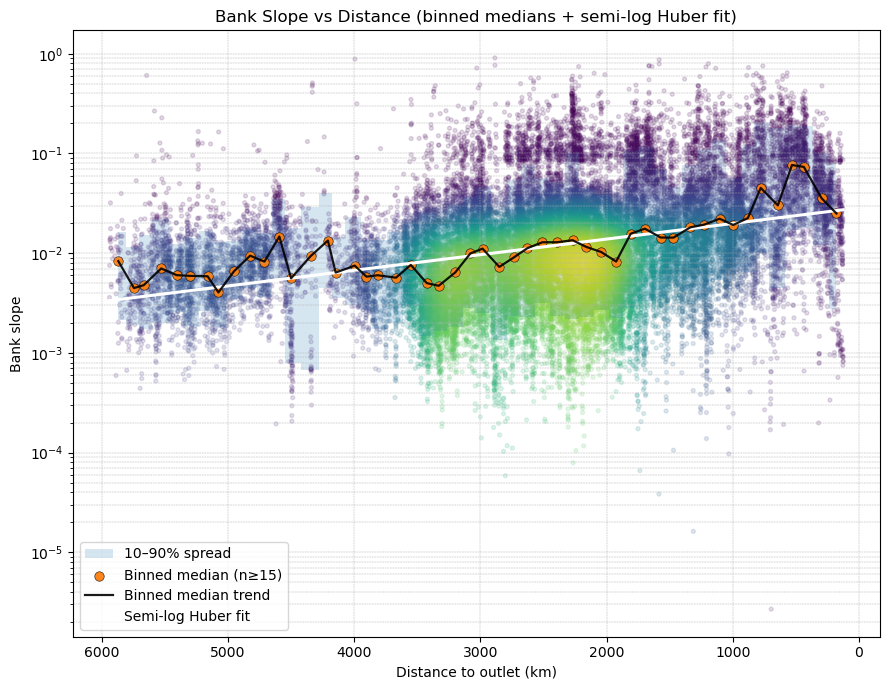

log10(a) = -1.545
b = -0.000
Trend: Slope ≈ 0.0285 · 10^(-0.000·Distance_km)


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from scipy.stats import gaussian_kde

# =========================
# 1) Prep & filtering
# =========================
d = df[(df['dist_out'] > 0) & (df['slope1'] > 0)].copy()
d['dist_km'] = d['dist_out'] / 1000.0

x = d['dist_km'].to_numpy()
y = d['slope1'].to_numpy()

# =========================
# 2) Helpers
# =========================
def nanpercentile_safe(a, q):
    a = pd.to_numeric(pd.Series(a), errors='coerce').dropna().to_numpy()
    if a.size == 0:
        return np.nan
    return np.percentile(a, q)

# =========================
# 3) Binning along distance
#    (equal-width by default, switch to equal-count if wanted)
# =========================
nbins = 50                 # tune based on your x-range & sample size
use_equal_count = False    # True -> quantile bins (reduces empty bins)
min_n = 15                 # minimum observations per bin to keep

if use_equal_count:
    # Rank to avoid qcut duplicate-bin issues when x has ties
    d['bin'] = pd.qcut(d['dist_km'].rank(method='first'), q=nbins, duplicates='drop')
else:
    d['bin'] = pd.cut(d['dist_km'], bins=nbins, include_lowest=True)

g = d.groupby('bin', observed=True)

agg = (
    g.agg(
        n=('slope1', 'size'),
        dist_mid=('dist_km', 'median'),                        # x for the bin
        slope_med=('slope1', 'median'),                        # median (linear space)
        slope_low=('slope1', lambda z: nanpercentile_safe(z, 10)),
        slope_high=('slope1', lambda z: nanpercentile_safe(z, 90)),
    )
    .reset_index(drop=True)
)

# Keep sufficiently populated, finite bins and sort by x
agg = agg[(agg['n'] >= min_n) &
          agg[['dist_mid','slope_med','slope_low','slope_high']].replace([np.inf,-np.inf], np.nan).notna().all(axis=1)]
agg = agg.sort_values('dist_mid')

# =========================
# 4) Semi-log regression: log10(y) ~ x  (Huber robust)
# =========================
mask_fit = np.isfinite(x) & np.isfinite(y) & (y > 0)
x_fit_in = x[mask_fit].reshape(-1,1)
logy_in = np.log10(y[mask_fit])

model = HuberRegressor()
model.fit(x_fit_in, logy_in)

x_fit = np.linspace(np.nanmin(x), np.nanmax(x), 200)
logy_pred = model.predict(x_fit.reshape(-1,1))
y_fit_line = 10**logy_pred

# =========================
# 5) Background density scatter (optional)
# =========================
mask_scatter = np.isfinite(x) & np.isfinite(y)
xy = np.vstack([x[mask_scatter], y[mask_scatter]])
if xy.shape[1] >= 5:
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    xb, yb, zb = x[mask_scatter][idx], y[mask_scatter][idx], z[idx]
else:
    xb, yb, zb = x[mask_scatter], y[mask_scatter], np.ones(mask_scatter.sum())

# =========================
# 6) Plot
# =========================
plt.figure(figsize=(9,7))

# Faint raw points
plt.scatter(xb, yb, c=zb, cmap='viridis', s=8, alpha=0.15, label='_nolegend_')

# Bin CI band (10–90%)
plt.fill_between(
    agg['dist_mid'].to_numpy(),
    agg['slope_low'].to_numpy(),
    agg['slope_high'].to_numpy(),
    alpha=0.18, step='mid', label='10–90% spread'
)

# Bin medians as points
plt.scatter(agg['dist_mid'], agg['slope_med'],
            s=46, edgecolor='k', lw=0.4, alpha=0.95,
            label=f"Binned median (n≥{min_n})")

# === NEW: line joining the binned medians
plt.plot(agg['dist_mid'], agg['slope_med'],
         color='black', linewidth=1.6, alpha=0.9,
         zorder=3, label="Binned median trend")

# Regression curve
plt.plot(x_fit, y_fit_line, linewidth=2.2, color='white',
         label="Semi-log Huber fit")

# Axes + scales
plt.yscale("log")
plt.xlabel("Distance to outlet (km)")
plt.ylabel("Bank slope")

# === NEW: reverse x-axis (so 0 km is at the right, headwaters on the left if that's your convention)
plt.gca().invert_xaxis()

plt.grid(True, which="both", linestyle="--", linewidth=0.35)
plt.title("Bank Slope vs Distance (binned medians + semi-log Huber fit)")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 7) Print model summary
# =========================
a_log10 = model.intercept_
b = model.coef_[0]
a = 10**a_log10
print(f"log10(a) = {a_log10:.3f}")
print(f"b = {b:.3f}")
print(f"Trend: Slope ≈ {a:.3g} · 10^({b:.3f}·Distance_km)")



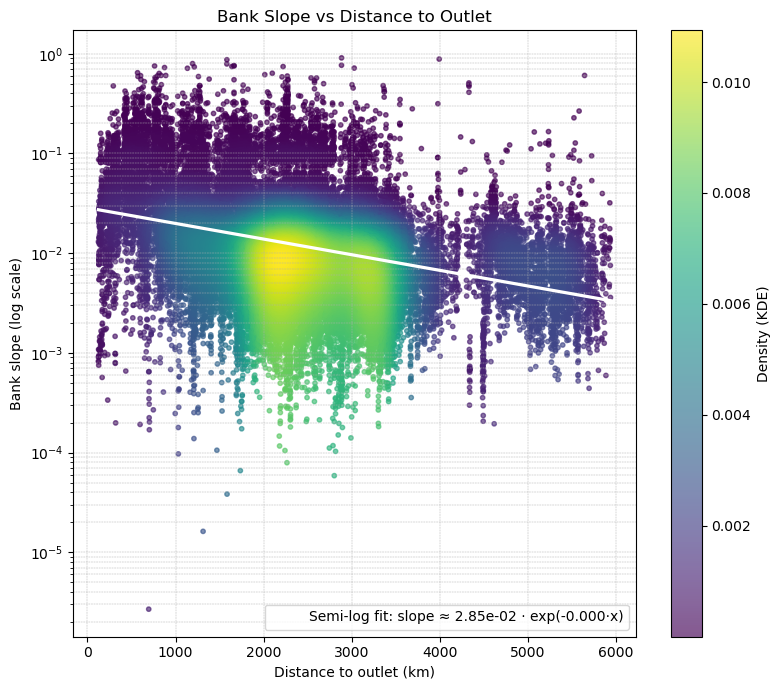

log10(a) = -1.5454048896780945
b = -0.00015678989011349805
Trend equation:
Slope ≈ 0.0285 · 10^(-0.000·Distance)


In [37]:
# Filter & convert distance
d = df[(df['dist_out'] > 0) & (df['slope1'] > 0)].copy()
d['dist_km'] = d['dist_out'] / 1000.0

x = d['dist_km'].values
y = d['slope1'].values

# === Robust power-law regression in log(y) only ===
logy = np.log10(y)

model = HuberRegressor()
model.fit(x.reshape(-1,1), logy)

# Create smooth trend line
x_fit = np.linspace(x.min(), x.max(), 200)
logy_pred = model.predict(x_fit.reshape(-1,1))
y_fit = 10**logy_pred

# === KDE Density ===
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()

x, y, z = x[idx], y[idx], z[idx]

# === Plot ===
plt.figure(figsize=(8,7))
sc = plt.scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.65)

# Trend overlay
plt.plot(x_fit, y_fit, color='white', linewidth=2.3,
         label=f"Semi-log fit: slope ≈ {10**model.intercept_:.2e} · exp({model.coef_[0]:.3f}·x)")

plt.yscale("log")
# plt.xscale("log")  <-- removed for semi-log plot

plt.grid(True, which="both", linestyle="--", linewidth=0.35)
plt.colorbar(sc, label="Density (KDE)")

plt.xlabel("Distance to outlet (km)")
plt.ylabel("Bank slope (log scale)")
plt.title("Bank Slope vs Distance to Outlet")

plt.legend()
plt.tight_layout()
plt.show()

print("log10(a) =", model.intercept_)
print("b =", model.coef_[0])
print(f"Trend equation:\nSlope ≈ {10**model.intercept_:.3g} · 10^({model.coef_[0]:.3f}·Distance)")


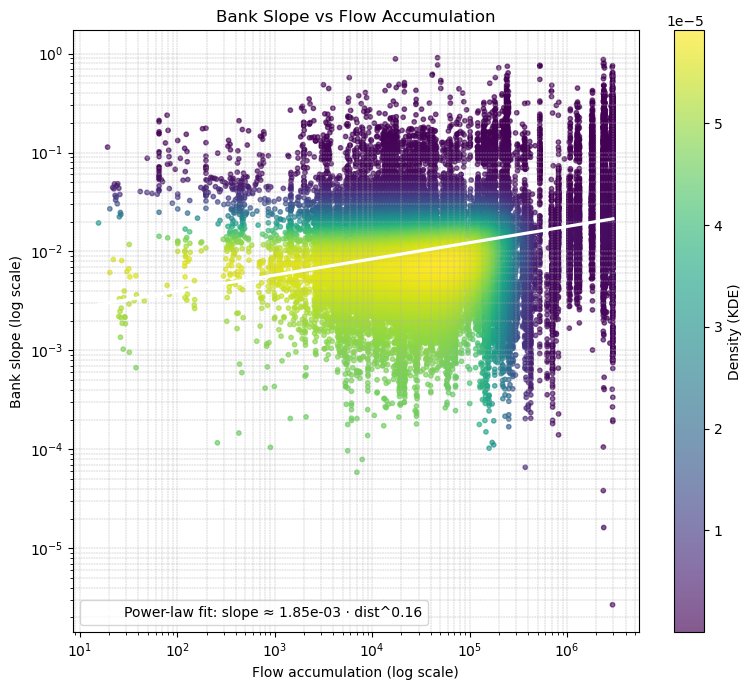

log10(a) = -2.731665249838428
b = 0.1640494098360528
Trend equation:
Slope ≈ 0.00185 · Distance^0.164


In [31]:
d = df[(df['facc'] > 0) & (df['slope1'] > 0)].copy()
d['dist_km'] = d['facc'] / 1000.0

x = d['facc'].values
y = d['slope1'].values

# === Robust power-law regression in log-log space ===
logx = np.log10(x)
logy = np.log10(y)

model = HuberRegressor()
model.fit(logx.reshape(-1,1), logy)

# Create smooth trend line
logx_fit = np.linspace(logx.min(), logx.max(), 200)
logy_pred = model.predict(logx_fit.reshape(-1,1))

x_fit = 10**logx_fit
y_fit = 10**logy_pred

# === KDE Density ===
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()

x, y, z = x[idx], y[idx], z[idx]

# === Plot ===
plt.figure(figsize=(8,7))
sc = plt.scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.65)

# Power-law trend overlay
plt.plot(x_fit, y_fit, color='white', linewidth=2.3,
         label=f"Power-law fit: slope ≈ {10**model.intercept_:.2e} · dist^{model.coef_[0]:.2f}")

plt.xscale("log")
plt.yscale("log")

plt.grid(True, which="both", linestyle="--", linewidth=0.35)
plt.colorbar(sc, label="Density (KDE)")

plt.xlabel("Flow accumulation (log scale)")
plt.ylabel("Bank slope (log scale)")
plt.title("Bank Slope vs Flow Accumulation")

plt.legend()
plt.tight_layout()
plt.show()

print("log10(a) =", model.intercept_)
print("b =", model.coef_[0])
print(f"Trend equation:\nSlope ≈ {10**model.intercept_:.3g} · Distance^{model.coef_[0]:.3f}")


In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(df['sinuosity'], df['slope1'], s=10, alpha=0.5)
plt.grid(True)
plt.xlim(0,20)
plt.xlabel('Sinuosity')
plt.ylabel('Bankslope')
plt.show()

/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_7443/901862293.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 20)


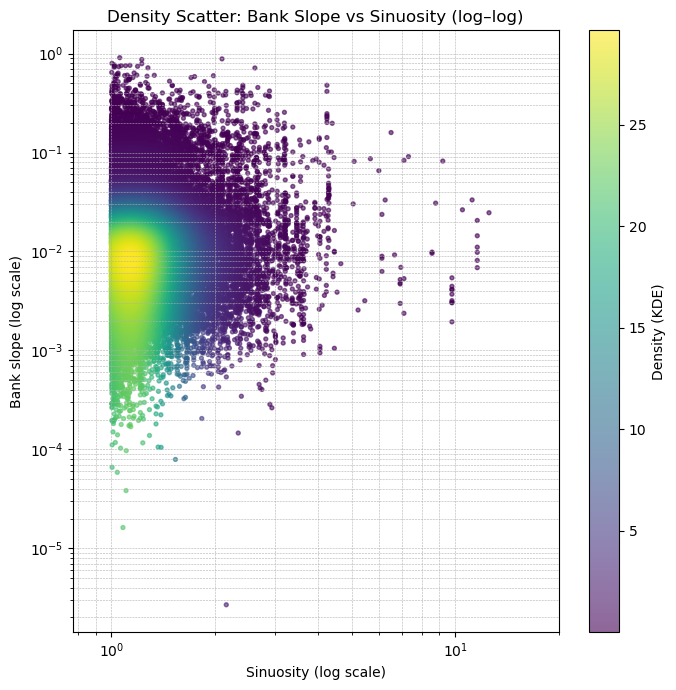

In [18]:
# Filter valid values for log scales
d = df[(df['sinuosity'] > 0) & (df['slope1'] > 0)].copy()

x = d['sinuosity'].values
y = d['slope1'].values

# KDE density estimation for each point
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort points by density (lowest first → high density on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(7, 7))
sc = plt.scatter(x, y, c=z, s=8, cmap='viridis', alpha=0.6)

plt.xscale("log")
plt.yscale("log")

plt.grid(True, which="both", linestyle="--", linewidth=0.4)

cbar = plt.colorbar(sc)
cbar.set_label("Density (KDE)")

plt.xlabel("Sinuosity (log scale)")
plt.ylabel("Bank slope (log scale)")
plt.xlim(0, 20)
plt.title("Density Scatter: Bank Slope vs Sinuosity (log–log)")

plt.tight_layout()
plt.show()

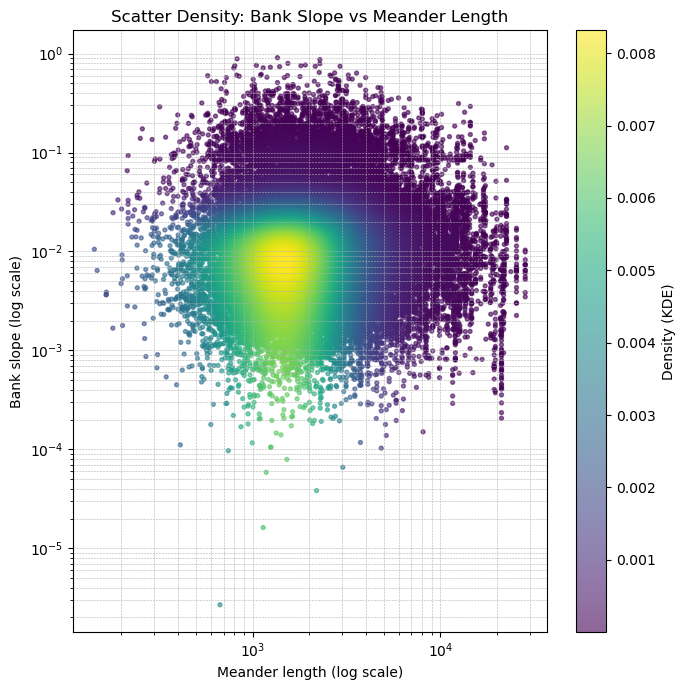

In [21]:
# Filter valid log-log values
c = df[(df['meand_len'] > 0) & (df['slope1'] > 0)].copy()
x = c['meand_len'].values
y = c['slope1'].values

# Compute local density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)   # density at each point

# Sort by density (so highest appear on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(7,7))
sc = plt.scatter(x, y, c=z, s=8, cmap='viridis', alpha=0.6)

plt.xscale("log")
plt.yscale("log")

plt.colorbar(sc, label="Density (KDE)")
plt.grid(True, which="both", linestyle="--", linewidth=0.4)

plt.xlabel("Meander length (log scale)")
plt.ylabel("Bank slope (log scale)")
plt.title("Scatter Density: Bank Slope vs Meander Length")

plt.tight_layout()
plt.show()


/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_7443/3573800666.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = d.groupby("bin")["slope1"].agg(


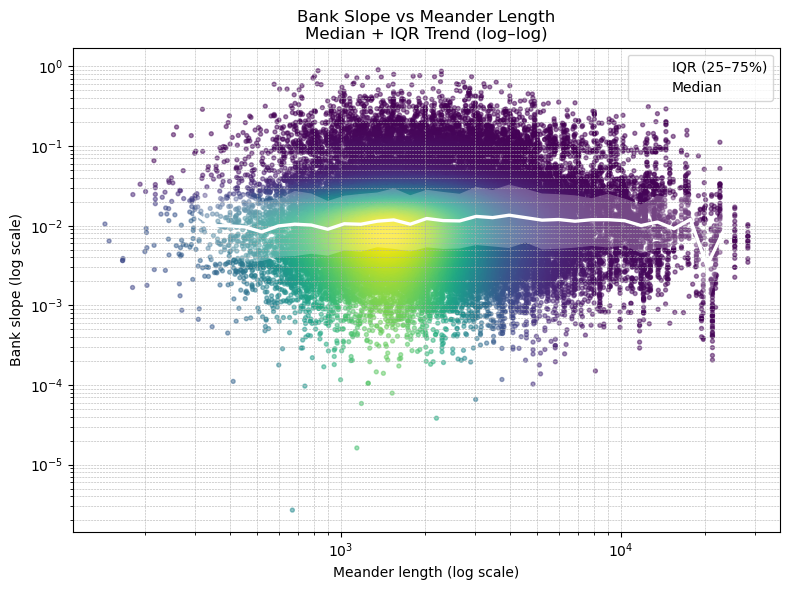

In [22]:
# Filter valid log-log values
d = df[(df['meand_len'] > 0) & (df['slope1'] > 0)].copy()

# Shortcuts
x = d['meand_len'].values
y = d['slope1'].values

# ===== Scatter Density as Base Layer =====
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=z, s=8, cmap='viridis', alpha=0.5)

# ===== Log bins =====
bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 40)
d["bin"] = pd.cut(d["meand_len"], bins=bins)

# Bin statistics
bin_stats = d.groupby("bin")["slope1"].agg(
    med="median",
    q25=lambda s: np.percentile(s, 25),
    q75=lambda s: np.percentile(s, 75),
    n="count"
).reset_index()

# Calculate bin midpoints for plotting
bin_stats["bin_mid"] = bins[:-1] + np.diff(bins)/2

# Keep bins with enough samples (avoid noisy ends)
bin_stats = bin_stats[bin_stats["n"] >= 30]

# ===== Trend Ribbon =====
plt.fill_between(
    bin_stats["bin_mid"], bin_stats["q25"], bin_stats["q75"],
    alpha=0.25, color="white", edgecolor="none",
    label="IQR (25–75%)"
)
plt.plot(
    bin_stats["bin_mid"], bin_stats["med"],
    color="white", linewidth=2.4,
    label="Median"
)

# ===== Axes and Aesthetics =====
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.4)

plt.xlabel("Meander length (log scale)")
plt.ylabel("Bank slope (log scale)")
plt.title("Bank Slope vs Meander Length\nMedian + IQR Trend (log–log)")
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
parquet_path = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet/Global_slopes_corrected.parquet"     # large parquet with node_id, slope1
shp_path     = "/Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/SA/sa_sword_nodes_hb62_v16.shp"         # large shapefile with node_id
out_path     = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_62.parquet"    # output GeoParquet

# --- 1) Read needed columns from Parquet (fast & memory efficient)
pq = pd.read_parquet(parquet_path, columns=["node_id", "slope1"])

# Ensure matching dtype for merging (robust choice: treat node_id as string)
pq["node_id"] = pq["node_id"].astype(str)

# --- Keep only the first slope1 per node_id
pq_first = (
    pq.dropna(subset=["node_id"])
      .drop_duplicates(subset=["node_id"], keep="first")
      [["node_id", "slope1"]]
)

print(f"Unique nodes in parquet: {len(pq_first):,}")

# --- 2) Load shapefile
gdf = gpd.read_file(shp_path, engine="pyogrio")
gdf["node_id"] = gdf["node_id"].astype(str)

print(f"Nodes in shapefile: {len(gdf):,}")

# --- 3) Merge & Filter unmatched nodes
gdf_merged = gdf.merge(pq_first, on="node_id", how="left", validate="m:1")

# Count mismatches before filtering
missing_count = gdf_merged["slope1"].isna().sum()
print(f"Unmatched nodes dropped: {missing_count:,}")

# Drop rows where slope1 was not found
gdf_merged = gdf_merged.dropna(subset=["slope1"])

# (Optional but safe) ensure numeric type
gdf_merged["slope1"] = pd.to_numeric(gdf_merged["slope1"], errors="coerce")

print(f"Final matched nodes: {len(gdf_merged):,}")

# --- 4) Save as GeoParquet
gdf_merged.to_parquet(out_path, index=False)

print(f"✅ Done! Merged dataset saved to:\n{out_path}")
print(f"Done. Wrote {len(gdf_merged):,} rows to {out_path}")

Unique nodes in parquet: 1,290,028
Nodes in shapefile: 1,118,138
Unmatched nodes dropped: 1,079,471
Final matched nodes: 38,667
✅ Done! Merged dataset saved to:
/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_62.parquet
Done. Wrote 38,667 rows to /Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_62.parquet


In [39]:
df2 = pd.read_parquet("/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet//slopes_sword_62.parquet")

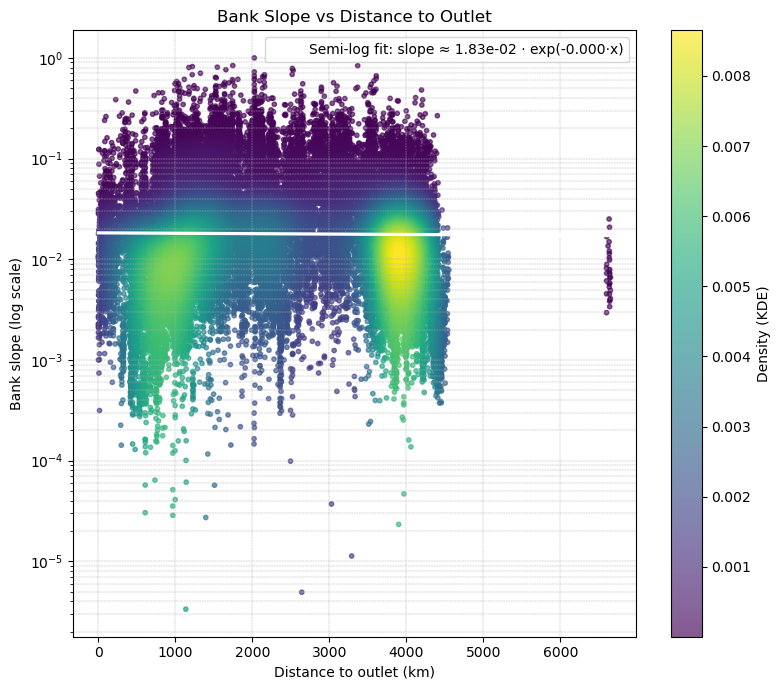

log10(a) = -1.7376902081913232
b = -4.0329178222070585e-06
Trend equation:
Slope ≈ 0.0183 · 10^(-0.000·Distance)


In [ ]:
# Filter & convert distance
d = df2[(df2['dist_out'] > 0) & (df2['slope1'] > 0)].copy()
d['dist_km'] = d['dist_out'] / 1000.0

x = d['dist_km'].values
y = d['slope1'].values

# === Robust power-law regression in log(y) only ===
logy = np.log10(y)

model = HuberRegressor()
model.fit(x.reshape(-1,1), logy)

# Create smooth trend line
x_fit = np.linspace(x.min(), x.max(), 200)
logy_pred = model.predict(x_fit.reshape(-1,1))
y_fit = 10**logy_pred

# === KDE Density ===
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()

x, y, z = x[idx], y[idx], z[idx]

# === Plot ===
plt.figure(figsize=(8,7))
sc = plt.scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.65)

# Trend overlay
plt.plot(x_fit, y_fit, color='white', linewidth=2.3,
         label=f"Semi-log fit: slope ≈ {10**model.intercept_:.2e} · exp({model.coef_[0]:.3f}·x)")

plt.yscale("log")
# plt.xscale("log")  <-- removed for semi-log plot

plt.grid(True, which="both", linestyle="--", linewidth=0.35)
plt.colorbar(sc, label="Density (KDE)")

plt.xlabel("Distance to outlet (km)")
plt.ylabel("Bank slope")
plt.title("Bank Slope vs Distance to Outlet")

plt.legend()
plt.tight_layout()
plt.show()

print("log10(a) =", model.intercept_)
print("b =", model.coef_[0])
print(f"Trend equation:\nSlope ≈ {10**model.intercept_:.3g} · 10^({model.coef_[0]:.3f}·Distance)")

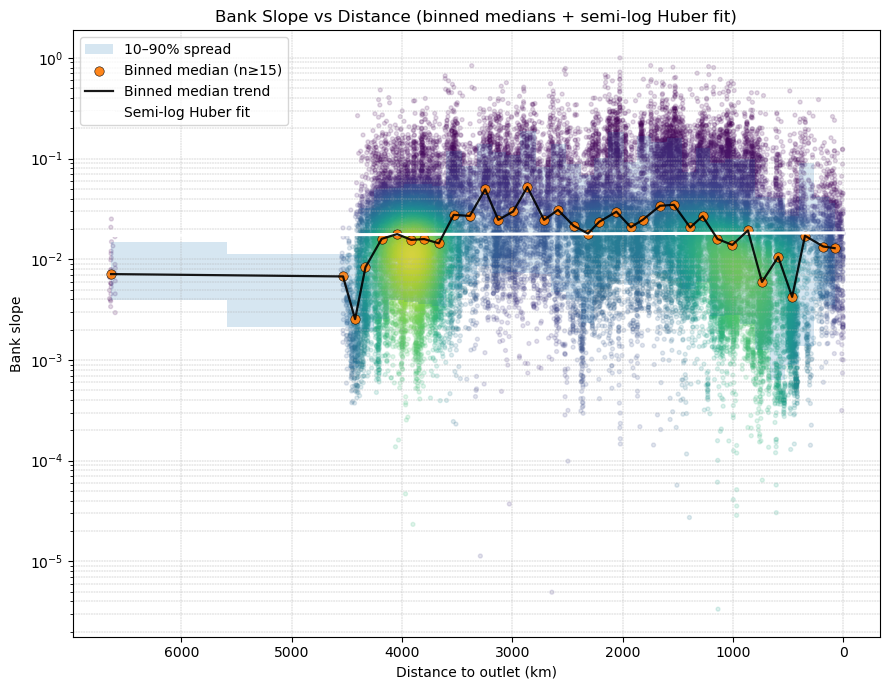

log10(a) = -1.738
b = -0.000
Trend: Slope ≈ 0.0183 · 10^(-0.000·Distance_km)


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from scipy.stats import gaussian_kde

# =========================
# 1) Prep & filtering
# =========================
d = df2[(df2['dist_out'] > 0) & (df2['slope1'] > 0)].copy()
d['dist_km'] = d['dist_out'] / 1000.0

x = d['dist_km'].to_numpy()
y = d['slope1'].to_numpy()

# =========================
# 2) Helpers
# =========================
def nanpercentile_safe(a, q):
    a = pd.to_numeric(pd.Series(a), errors='coerce').dropna().to_numpy()
    if a.size == 0:
        return np.nan
    return np.percentile(a, q)

# =========================
# 3) Binning along distance
#    (equal-width by default, switch to equal-count if wanted)
# =========================
nbins = 50                 # tune based on your x-range & sample size
use_equal_count = False    # True -> quantile bins (reduces empty bins)
min_n = 15                 # minimum observations per bin to keep

if use_equal_count:
    # Rank to avoid qcut duplicate-bin issues when x has ties
    d['bin'] = pd.qcut(d['dist_km'].rank(method='first'), q=nbins, duplicates='drop')
else:
    d['bin'] = pd.cut(d['dist_km'], bins=nbins, include_lowest=True)

g = d.groupby('bin', observed=True)

agg = (
    g.agg(
        n=('slope1', 'size'),
        dist_mid=('dist_km', 'median'),                        # x for the bin
        slope_med=('slope1', 'median'),                        # median (linear space)
        slope_low=('slope1', lambda z: nanpercentile_safe(z, 10)),
        slope_high=('slope1', lambda z: nanpercentile_safe(z, 90)),
    )
    .reset_index(drop=True)
)

# Keep sufficiently populated, finite bins and sort by x
agg = agg[(agg['n'] >= min_n) &
          agg[['dist_mid','slope_med','slope_low','slope_high']].replace([np.inf,-np.inf], np.nan).notna().all(axis=1)]
agg = agg.sort_values('dist_mid')

# =========================
# 4) Semi-log regression: log10(y) ~ x  (Huber robust)
# =========================
mask_fit = np.isfinite(x) & np.isfinite(y) & (y > 0)
x_fit_in = x[mask_fit].reshape(-1,1)
logy_in = np.log10(y[mask_fit])

model = HuberRegressor()
model.fit(x_fit_in, logy_in)

x_fit = np.linspace(np.nanmin(x), np.nanmax(x), 200)
logy_pred = model.predict(x_fit.reshape(-1,1))
y_fit_line = 10**logy_pred

# =========================
# 5) Background density scatter (optional)
# =========================
mask_scatter = np.isfinite(x) & np.isfinite(y)
xy = np.vstack([x[mask_scatter], y[mask_scatter]])
if xy.shape[1] >= 5:
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    xb, yb, zb = x[mask_scatter][idx], y[mask_scatter][idx], z[idx]
else:
    xb, yb, zb = x[mask_scatter], y[mask_scatter], np.ones(mask_scatter.sum())

# =========================
# 6) Plot
# =========================
plt.figure(figsize=(9,7))

# Faint raw points
plt.scatter(xb, yb, c=zb, cmap='viridis', s=8, alpha=0.15, label='_nolegend_')

# Bin CI band (10–90%)
plt.fill_between(
    agg['dist_mid'].to_numpy(),
    agg['slope_low'].to_numpy(),
    agg['slope_high'].to_numpy(),
    alpha=0.18, step='mid', label='10–90% spread'
)

# Bin medians as points
plt.scatter(agg['dist_mid'], agg['slope_med'],
            s=46, edgecolor='k', lw=0.4, alpha=0.95,
            label=f"Binned median (n≥{min_n})")

# === NEW: line joining the binned medians
plt.plot(agg['dist_mid'], agg['slope_med'],
         color='black', linewidth=1.6, alpha=0.9,
         zorder=3, label="Binned median trend")

# Regression curve
plt.plot(x_fit, y_fit_line, linewidth=2.2, color='white',
         label="Semi-log Huber fit")

# Axes + scales
plt.yscale("log")
plt.xlabel("Distance to outlet (km)")
plt.ylabel("Bank slope")

# === NEW: reverse x-axis (so 0 km is at the right, headwaters on the left if that's your convention)
plt.gca().invert_xaxis()

plt.grid(True, which="both", linestyle="--", linewidth=0.35)
plt.title("Bank Slope vs Distance (binned medians + semi-log Huber fit)")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 7) Print model summary
# =========================
a_log10 = model.intercept_
b = model.coef_[0]
a = 10**a_log10
print(f"log10(a) = {a_log10:.3f}")
print(f"b = {b:.3f}")
print(f"Trend: Slope ≈ {a:.3g} · 10^({b:.3f}·Distance_km)")



/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_7443/2823689413.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 20)


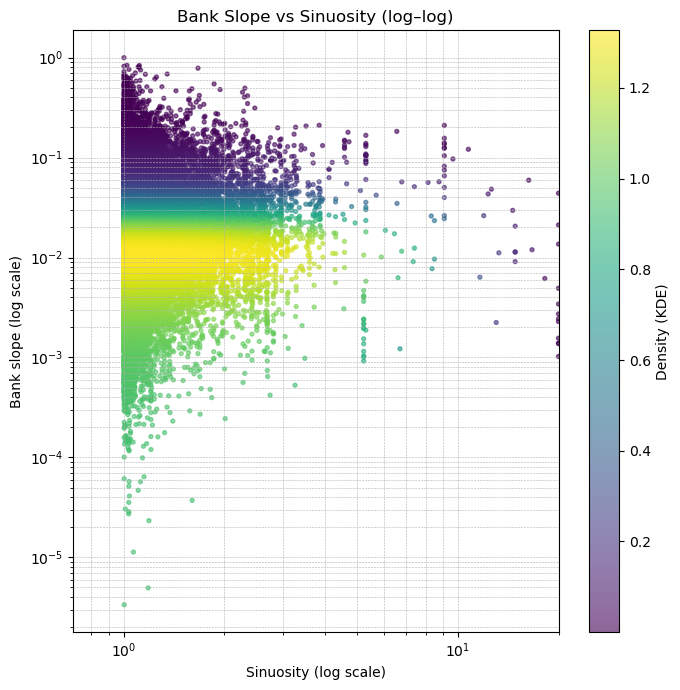

In [35]:
# Filter valid values for log scales
d = df2[(df2['sinuosity'] > 0) & (df2['slope1'] > 0)].copy()

x = d['sinuosity'].values
y = d['slope1'].values

# KDE density estimation for each point
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort points by density (lowest first → high density on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(7, 7))
sc = plt.scatter(x, y, c=z, s=8, cmap='viridis', alpha=0.6)

plt.xscale("log")
plt.yscale("log")

plt.grid(True, which="both", linestyle="--", linewidth=0.4)

cbar = plt.colorbar(sc)
cbar.set_label("Density (KDE)")

plt.xlabel("Sinuosity (log scale)")
plt.ylabel("Bank slope (log scale)")
plt.xlim(0, 20)
plt.title("Bank Slope vs Sinuosity (log–log)")

plt.tight_layout()
plt.show()

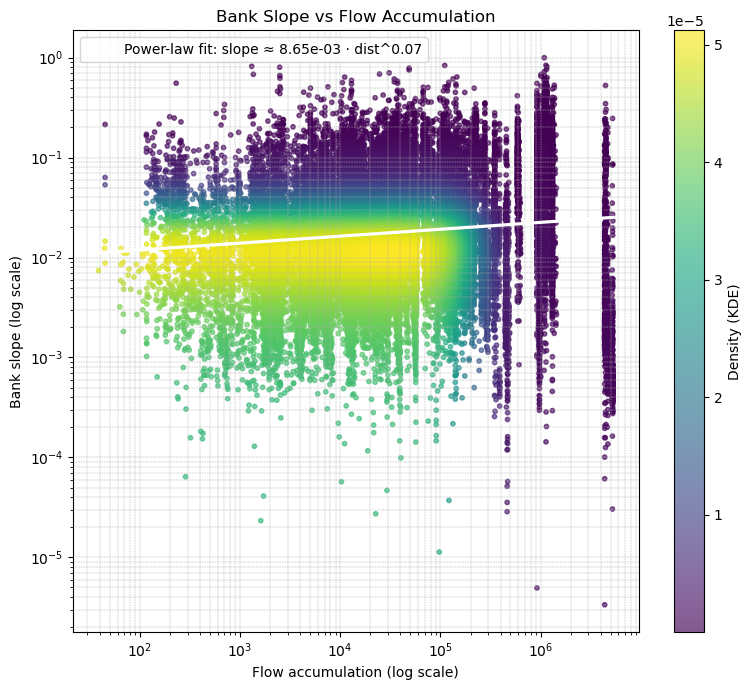

log10(a) = -2.0631797625092063
b = 0.06916279772024438
Trend equation:
Slope ≈ 0.00865 · Distance^0.069


In [32]:
d = df2[(df2['facc'] > 0) & (df2['slope1'] > 0)].copy()
d['dist_km'] = d['facc'] / 1000.0

x = d['facc'].values
y = d['slope1'].values

# === Robust power-law regression in log-log space ===
logx = np.log10(x)
logy = np.log10(y)

model = HuberRegressor()
model.fit(logx.reshape(-1,1), logy)

# Create smooth trend line
logx_fit = np.linspace(logx.min(), logx.max(), 200)
logy_pred = model.predict(logx_fit.reshape(-1,1))

x_fit = 10**logx_fit
y_fit = 10**logy_pred

# === KDE Density ===
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()

x, y, z = x[idx], y[idx], z[idx]

# === Plot ===
plt.figure(figsize=(8,7))
sc = plt.scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.65)

# Power-law trend overlay
plt.plot(x_fit, y_fit, color='white', linewidth=2.3,
         label=f"Power-law fit: slope ≈ {10**model.intercept_:.2e} · dist^{model.coef_[0]:.2f}")

plt.xscale("log")
plt.yscale("log")

plt.grid(True, which="both", linestyle="--", linewidth=0.35)
plt.colorbar(sc, label="Density (KDE)")

plt.xlabel("Flow accumulation (log scale)")
plt.ylabel("Bank slope (log scale)")
plt.title("Bank Slope vs Flow Accumulation")

plt.legend()
plt.tight_layout()
plt.show()

print("log10(a) =", model.intercept_)
print("b =", model.coef_[0])
print(f"Trend equation:\nSlope ≈ {10**model.intercept_:.3g} · Distance^{model.coef_[0]:.3f}")

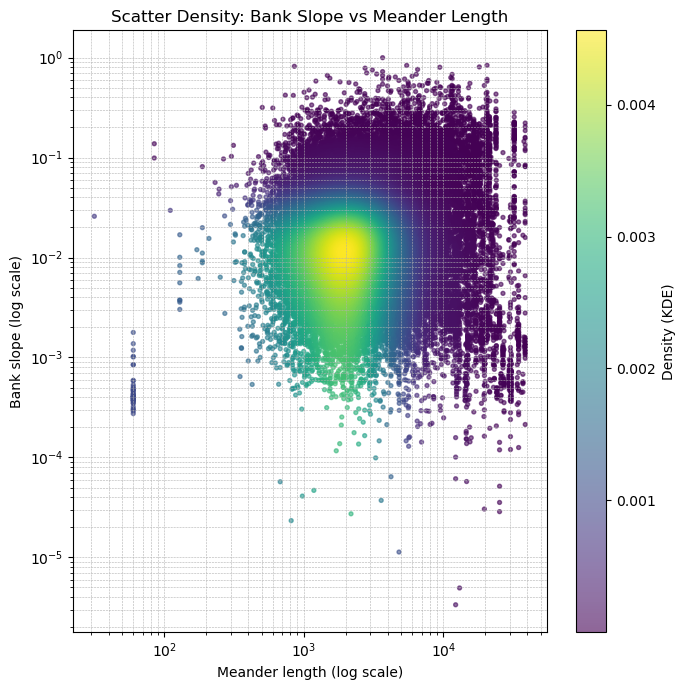

In [34]:
# Filter valid log-log values
c = df2[(df2['meand_len'] > 0) & (df2['slope1'] > 0)].copy()
x = c['meand_len'].values
y = c['slope1'].values

# Compute local density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)   # density at each point

# Sort by density (so highest appear on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(7,7))
sc = plt.scatter(x, y, c=z, s=8, cmap='viridis', alpha=0.6)

plt.xscale("log")
plt.yscale("log")

plt.colorbar(sc, label="Density (KDE)")
plt.grid(True, which="both", linestyle="--", linewidth=0.4)

plt.xlabel("Meander length (log scale)")
plt.ylabel("Bank slope (log scale)")
plt.title("Scatter Density: Bank Slope vs Meander Length")

plt.tight_layout()
plt.show()


In [4]:
import os, glob, gc, uuid
import pandas as pd
import geopandas as gpd
import duckdb
from pyogrio import read_info  # cheap schema probe



parquet_path = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet/Global_slopes_corrected.parquet"
shp_root     = "/Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/"
tmp_dir      = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet/_tmp_parts"
out_parquet  = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet/global_sword_with_slope.parquet"

# Clean outputs
os.makedirs(tmp_dir, exist_ok=True)
if os.path.exists(out_parquet):
    os.remove(out_parquet)

# --- Build slope1 lookup (first per node_id)
pq = pd.read_parquet(parquet_path, columns=["node_id", "slope1"]).dropna(subset=["node_id"])
pq["node_id"] = pq["node_id"].astype(str)
slope_map = pq.drop_duplicates("node_id", keep="first").set_index("node_id")["slope1"]
print(f"Unique Parquet nodes: {len(slope_map):,}")

# --- Walk shapefiles -> add slope1 -> write parts (KEEP ALL COLUMNS)
shps = glob.glob(os.path.join(shp_root, "**", "*.shp"), recursive=True)
print(f"Found {len(shps):,} shapefiles")

parts = 0
for i, shp in enumerate(shps, 1):
    try:
        gdf = gpd.read_file(shp, engine="pyogrio")
        if "node_id" not in gdf.columns:
            print(f"[{i}/{len(shps)}] SKIP (no node_id): {shp}")
            continue

        gdf["node_id"] = gdf["node_id"].astype(str)
        gdf["slope1"]  = gdf["node_id"].map(slope_map)
        gdf = gdf.dropna(subset=["slope1"])
        gdf["slope1"]  = pd.to_numeric(gdf["slope1"], errors="coerce")
        gdf = gdf.dropna(subset=["slope1"])

        if gdf.empty:
            print(f"[{i}/{len(shps)}] {os.path.basename(shp)} → 0 kept")
            continue

        # Debug: ensure we’re not down to 3 cols
        print(f"[{i}/{len(shps)}] {os.path.basename(shp)} cols before write: {len(gdf.columns)}")

        # IMPORTANT: do NOT subset columns here; keep them all + geometry
        part_path = os.path.join(tmp_dir, f"part-{uuid.uuid4().hex}.parquet")
        gdf.to_parquet(part_path, index=False)
        parts += 1

        del gdf
        gc.collect()

    except Exception as e:
        print(f"[{i}/{len(shps)}] ERROR {shp}: {e}")

if parts == 0:
    raise RuntimeError("No parts were written. Check node_id matches or paths.")

# --- Final stitch into ONE Parquet, UNION BY NAME (keeps all attributes)
con = duckdb.connect()
con.execute(f"""
    COPY (
        SELECT * FROM read_parquet('{tmp_dir}/*.parquet', union_by_name=true)
    )
    TO '{out_parquet}' (FORMAT PARQUET);
""")
# Optional: preview schema to verify many columns survived
schema_preview = con.execute(f"DESCRIBE SELECT * FROM read_parquet('{out_parquet}')").df()
con.close()

print(f"\n✅ Single Parquet written with ALL shapefile attributes + slope1:\n{out_parquet}")
print(f"Columns in final file: {len(schema_preview)}")
print(schema_preview.head(15))
print(f"🧹 You may remove temp parts: rm -rf '{tmp_dir}'")


Unique Parquet nodes: 1,290,028
Found 120 shapefiles
[1/120] SKIP (no node_id): /Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/NA/na_sword_reaches_hb71_v16.shp
[2/120] SKIP (no node_id): /Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/NA/na_sword_reaches_hb85_v16.shp
[3/120] na_sword_nodes_hb86_v16.shp → 0 kept
[4/120] SKIP (no node_id): /Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/NA/na_sword_reaches_hb78_v16.shp
[5/120] na_sword_nodes_hb72_v16.shp cols before write: 27
[6/120] na_sword_nodes_hb73_v16.shp cols before write: 27
[7/120] SKIP (no node_id): /Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/NA/na_sword_reaches_hb84_v16.shp
[8/120] na_sword_nodes_hb85_v16.shp cols before write: 27
[9/120] na_sword_nodes_hb71_v16.shp cols before write: 27
[10/120] SKIP (no node_id): /Volumes/Science_SSD/Dissertation/0_data/External/SWORD/shp_v16/NA/na_sword_reaches_hb72_v16.shp
[11/120] na_sword_nodes_hb78_v16.shp cols before 

In [5]:
df = pd.read_parquet("/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/parquet/global_sword_with_slope.parquet")
df

node_id    slope1  \
0        84100100010461  0.001535   
1        84100100010581  0.000872   
2        84100100010601  0.000732   
3        84100100050061  0.001443   
4        84100100050141  0.005267   
...                 ...       ...   
6446790  64401900280301  0.015787   
6446791  64401900280541  0.030963   
6446792  64401900430011  0.011012   
6446793  64401900430031  0.028439   
6446794  64401900430451  0.005831   

                                                  geometry   x   y  node_len  \
0        b'\x01\x01\x00\x00\x00\xd8*_0\xeaX_\xc0ED\xe6\... NaN NaN       NaN   
1        b'\x01\x01\x00\x00\x00?j\xa1B\xc0U_\xc0\x90\xd... NaN NaN       NaN   
2        b'\x01\x01\x00\x00\x009$1\x82\x17U_\xc0\x07\xc... NaN NaN       NaN   
3        b'\x01\x01\x00\x00\x00\xdb\x8d\xac\x8f\x96\x18... NaN NaN       NaN   
4        b'\x01\x01\x00\x00\x00\xacynY\x02\x17_\xc0AJ\x... NaN NaN       NaN   
...                                                    ...  ..  ..       ...   
6446790  b'\x01\x01\x00\x00\x00\xb9G\xc36\x83QP\xc0_\xb... NaN NaN       NaN   
6446791  b'\x01\x01\x00\x00\x00Y{\xdcJ\x83PP\xc0\xfe\xf... NaN NaN       NaN   
6446792  b'\x01\x01\x00\x00\x00-\x8d\xd56\x1a]P\xc0%\x9... NaN NaN       NaN   
6446793  b'\x01\x01\x00\x00\x00\xadF:\xbcW]P\xc0\xf5\x1... NaN NaN       NaN   
6446794  b'\x01\x01\x00\x00\x00\x85\xb8\x0e\xec,`P\xc0\... NaN NaN       NaN   

         reach_id  wse  wse_var  width  ...  dist_out  lakeflag  max_width  \
0             NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
1             NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
2             NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
3             NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
4             NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
...           ...  ...      ...    ...  ...       ...       ...        ...   
6446790       NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
6446791       NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
6446792       NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
6446793       NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   
6446794       NaN  NaN      NaN    NaN  ...       NaN       NaN        NaN   

         manual_add  meand_len  sinuosity  type  river_name  edit_flag  \
0               NaN        NaN        NaN   NaN        None       None   
1               NaN        NaN        NaN   NaN        None       None   
2               NaN        NaN        NaN   NaN        None       None   
3               NaN        NaN        NaN   NaN        None       None   
4               NaN        NaN        NaN   NaN        None       None   
...             ...        ...        ...   ...         ...        ...   
6446790         NaN        NaN        NaN   NaN        None       None   
6446791         NaN        NaN        NaN   NaN        None       None   
6446792         NaN        NaN        NaN   NaN        None       None   
6446793         NaN        NaN        NaN   NaN        None       None   
6446794         NaN        NaN        NaN   NaN        None       None   

         trib_flag  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
6446790        NaN  
6446791        NaN  
6446792        NaN  
6446793        NaN  
6446794        NaN  

[6446795 rows x 27 columns]